In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import networkx as nx
import community as community_louvain
from collections import Counter, defaultdict
import netwulf as nw

https://www.kaggle.com/datasets/jfreyberg/spotify-artist-feature-collaboration-network?resource=download&fbclid=IwZXh0bgNhZW0CMTEAAR5jxk4FClm9GBFvCklV4Ga5SRwON3ajfqLdOMjFqN1uereEEduffCtjEbkjJg_aem_YUf8t7fIjwbCWiHS_vrVcg

In [30]:
artists = pd.read_csv("american_artists.csv")
artists_us_only = artists[artists["Country"] == "US"]
artists_us_only

# the 1207 most popular american artists
# we will find a method that allow us to extract even more artists
len(list(artists_us_only["Name"]))

1207

In [31]:
import pandas as pd
import ast

# Load the nodes and edges
nodes_df = pd.read_csv('nodes.csv')
edges_df = pd.read_csv('edges.csv')


# sort out all orther rows, which are not in the artists_us_only name list
# Ensure artist names are comparable (strip whitespaces, unify casing if necessary)
us_artist_names = set(artists_us_only["Name"].str.strip())

# Filter the nodes to only include US artists
nodes_df = nodes_df[nodes_df["name"].str.strip().isin(us_artist_names)]

nodes_df['genres'] = nodes_df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Output for inspection
print(f"Filtered nodes: {len(nodes_df)}")
nodes_df


Filtered nodes: 1259


spotify_id            name  followers  popularity  \
15      3xs0LEzcPXtgNfMNcHzLIP        Rockwell    40344.0          58   
54      0LyOADBjj28cbvJWTXUEGA    Loren Allred   111839.0          58   
85      7wU2WGCJ8HxkekHHE2QLul           Fuego   253571.0          67   
88      2l35CQqtYRh3d8ZIiBep4v            MKTO   995449.0          66   
152     7h1amg0X7Q5d0D5KfuyKTg           Pyrex    29130.0          57   
...                        ...             ...        ...         ...   
155024  79QO0Xmn1dZhvaLicS2Yrs  The Night Game    37079.0          44   
155417  2OYcRtVsj2M6KhIiO5gQun          Twista       17.0           3   
155445  1h8J8ik3ANaCWB9l7NZF10            Malo       26.0           3   
155870  3a9qv6NLHnsVxJUtKOMHvD  The Glitch Mob   538974.0          61   
155955  5Bz409CcH4Rk3sqhmOpcxf        Rockwell    11988.0          26   

                                                   genres  \
15                                                     []   
54             [deep talent show, hollywood, movie tunes]   
85      [latin hip hop, rap dominicano, reggaeton, reg...   
88      [dance pop, pop, pop rap, pop rock, post-teen ...   
152                      [italian hip hop, trap italiana]   
...                                                   ...   
155024         [indie poptimism, modern alternative rock]   
155417                                                 []   
155445                                                 []   
155870  [edm, electro house, glitch, glitch hop, indie...   
155955                                                 []   

                                               chart_hits  
15      ['us (1)', 'gb (1)', 'at (1)', 'be (1)', 'ca (...  
54      ['us (1)', 'gb (2)', 'au (2)', 'at (1)', 'cz (...  
85      ['ar (3)', 'bo (2)', 'cl (2)', 'co (3)', 'cr (...  
88      ['us (3)', 'gb (2)', 'au (5)', 'at (1)', 'be (...  
152                                            ['it (3)']  
...                                                   ...  
155024                                                NaN  
155417                                                NaN  
155445                                                NaN  
155870                                                NaN  
155955                                                NaN  

[1259 rows x 6 columns]

In [32]:
duplicate_names = nodes_df["name"].value_counts()
duplicates = duplicate_names[duplicate_names > 1]
print(f"Number of duplicate names: {len(duplicates)}")
print(duplicates)


Number of duplicate names: 81
name
Mario          8
MK             7
Trouble        7
Fuego          6
Malo           6
              ..
Bas            2
Pyrex          2
Kenny Beats    2
Mario Cash     2
Jaill          2
Name: count, Length: 81, dtype: int64


In [33]:
def split_artists_by_genre(nodes_df, genre_names, exclusive=False):    
    nodes_df = nodes_df.copy()

    filtered_dfs = []

    for genre in genre_names:
        if exclusive:
            other_genres = [g for g in genre_names if g != genre]
            
            df = nodes_df[
                nodes_df['genres'].apply(
                    lambda genres: genre in ' '.join(genres) and all(other not in ' '.join(genres) for other in other_genres)
                )
            ].copy()
        else:
             df = nodes_df[
                nodes_df['genres'].apply(
                    lambda genres: genre in ' '.join(genres)
                )
            ].copy()
        
        filtered_dfs.append(df)

    return filtered_dfs

def get_Graph_with_names(nodes_df, edges_df, verbose=True):
    nodes_df = nodes_df.dropna(subset=['spotify_id', 'name'])
    edges_df = edges_df.dropna(subset=['id_0', 'id_1'])

    # Build ID to name map
    id_to_name = dict(zip(nodes_df['spotify_id'], nodes_df['name']))
    allowed_ids = set(id_to_name.keys())

    # Create graph with artist names as nodes
    G = nx.Graph()

    for _, row in nodes_df.iterrows():
        artist_name = row['name']
        followers = row['followers'] if not pd.isna(row['followers']) else 0
        popularity = row['popularity'] if not pd.isna(row['popularity']) else 0
        genres = row['genres']
        chart_hits = row['chart_hits'] if not pd.isna(row['chart_hits']) else []

        G.add_node(artist_name, followers=followers, popularity=popularity,
                   genres=genres, chart_hits=chart_hits)

    for _, row in edges_df.iterrows():
        id_0, id_1 = row['id_0'], row['id_1']
        if id_0 in allowed_ids and id_1 in allowed_ids:
            name_0 = id_to_name.get(id_0)
            name_1 = id_to_name.get(id_1)
            if name_0 and name_1:
                G.add_edge(name_0, name_1)

    if verbose:
        print(f"Number of nodes: {G.number_of_nodes()}")
        print(f"Number of edges: {G.number_of_edges()}")
        print(f"Network density: {nx.density(G)}")

    return G

def get_n_largest_component(G, n):
    return sorted(nx.connected_components(G), key=len, reverse=True)[n]

def apply_louvain(G, verbose=True):
    partition = community_louvain.best_partition(G)

    nx.set_node_attributes(G, partition, 'community')
    
    if verbose:
        community_sizes = Counter(partition.values())
        sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)
        for community_id, size in sorted_communities:
            print(f"Community {community_id}: {size} nodes")
    
    communities = defaultdict(list)
    for node, community_id in partition.items():
        communities[community_id].append(node)
    
    sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)
    return sorted_communities
        
def get_community_subgraph(G, community_id):
    nodes_in_community = [n for n, attr in G.nodes(data=True) if attr.get('community') == community_id]
    
    subgraph = G.subgraph(nodes_in_community).copy()
    
    return subgraph

def get_combined_louvain_splitted_graph(G):
    _G = G.copy()
    partition = community_louvain.best_partition(_G)
    nx.set_node_attributes(_G, partition, 'community')

    combined_G = nx.Graph()
    
    combined_G.add_nodes_from(_G.nodes(data=True))

    for u, v in _G.edges():
        if partition[u] == partition[v]:
            combined_G.add_edge(u, v, **_G[u][v])

    return combined_G

def print_top_collaborators(G, n):
    top_collaborators = sorted(G.degree, key=lambda x: x[1], reverse=True)[:n]

    print(f"Top {n} artists with the most collaborations:")
    for rank, (artist, degree) in enumerate(top_collaborators, start=1):
        print(f"{rank}. {artist} — {degree} collaborations")


In [34]:
pop_df, rap_df = split_artists_by_genre(nodes_df, ["pop", "rap"])

len(pop_df), len(rap_df)

(541, 329)

In [35]:
G_pop = get_Graph_with_names(pop_df, edges_df)
G_rap = get_Graph_with_names(rap_df, edges_df)

Number of nodes: 537
Number of edges: 1992
Network density: 0.013841407487701159
Number of nodes: 326
Number of edges: 2151
Network density: 0.04060405851816895


In [36]:
print_top_collaborators(G_rap, 10)

Top 10 artists with the most collaborations:
1. Ty Dolla $ign — 88 collaborations
2. The Game — 70 collaborations
3. 2 Chainz — 68 collaborations
4. Wiz Khalifa — 67 collaborations
5. Young Thug — 66 collaborations
6. Snoop Dogg — 66 collaborations
7. T.I. — 57 collaborations
8. DJ Khaled — 57 collaborations
9. YG — 55 collaborations
10. Juicy J — 54 collaborations


In [37]:
G_rap_splittet = get_combined_louvain_splitted_graph(G_rap)

In [38]:
communities = apply_louvain(G_rap)
largest_community_id = communities[0][0]

G_largest_rap_community = get_community_subgraph(G_rap, largest_community_id)
G_largest_rap_community_splitted = get_combined_louvain_splitted_graph(G_largest_rap_community)

Community 3: 64 nodes
Community 4: 59 nodes
Community 13: 58 nodes
Community 11: 47 nodes
Community 18: 27 nodes
Community 7: 19 nodes
Community 23: 2 nodes
Community 1: 1 nodes
Community 2: 1 nodes
Community 10: 1 nodes
Community 12: 1 nodes
Community 16: 1 nodes
Community 17: 1 nodes
Community 19: 1 nodes
Community 20: 1 nodes
Community 21: 1 nodes
Community 22: 1 nodes
Community 25: 1 nodes
Community 26: 1 nodes
Community 27: 1 nodes
Community 28: 1 nodes
Community 29: 1 nodes
Community 31: 1 nodes
Community 32: 1 nodes
Community 33: 1 nodes
Community 35: 1 nodes
Community 37: 1 nodes
Community 38: 1 nodes
Community 39: 1 nodes
Community 42: 1 nodes
Community 43: 1 nodes
Community 45: 1 nodes
Community 46: 1 nodes
Community 47: 1 nodes
Community 48: 1 nodes
Community 50: 1 nodes
Community 51: 1 nodes
Community 52: 1 nodes
Community 53: 1 nodes
Community 54: 1 nodes
Community 55: 1 nodes
Community 56: 1 nodes
Community 41: 1 nodes
Community 44: 1 nodes
Community 14: 1 nodes
Community

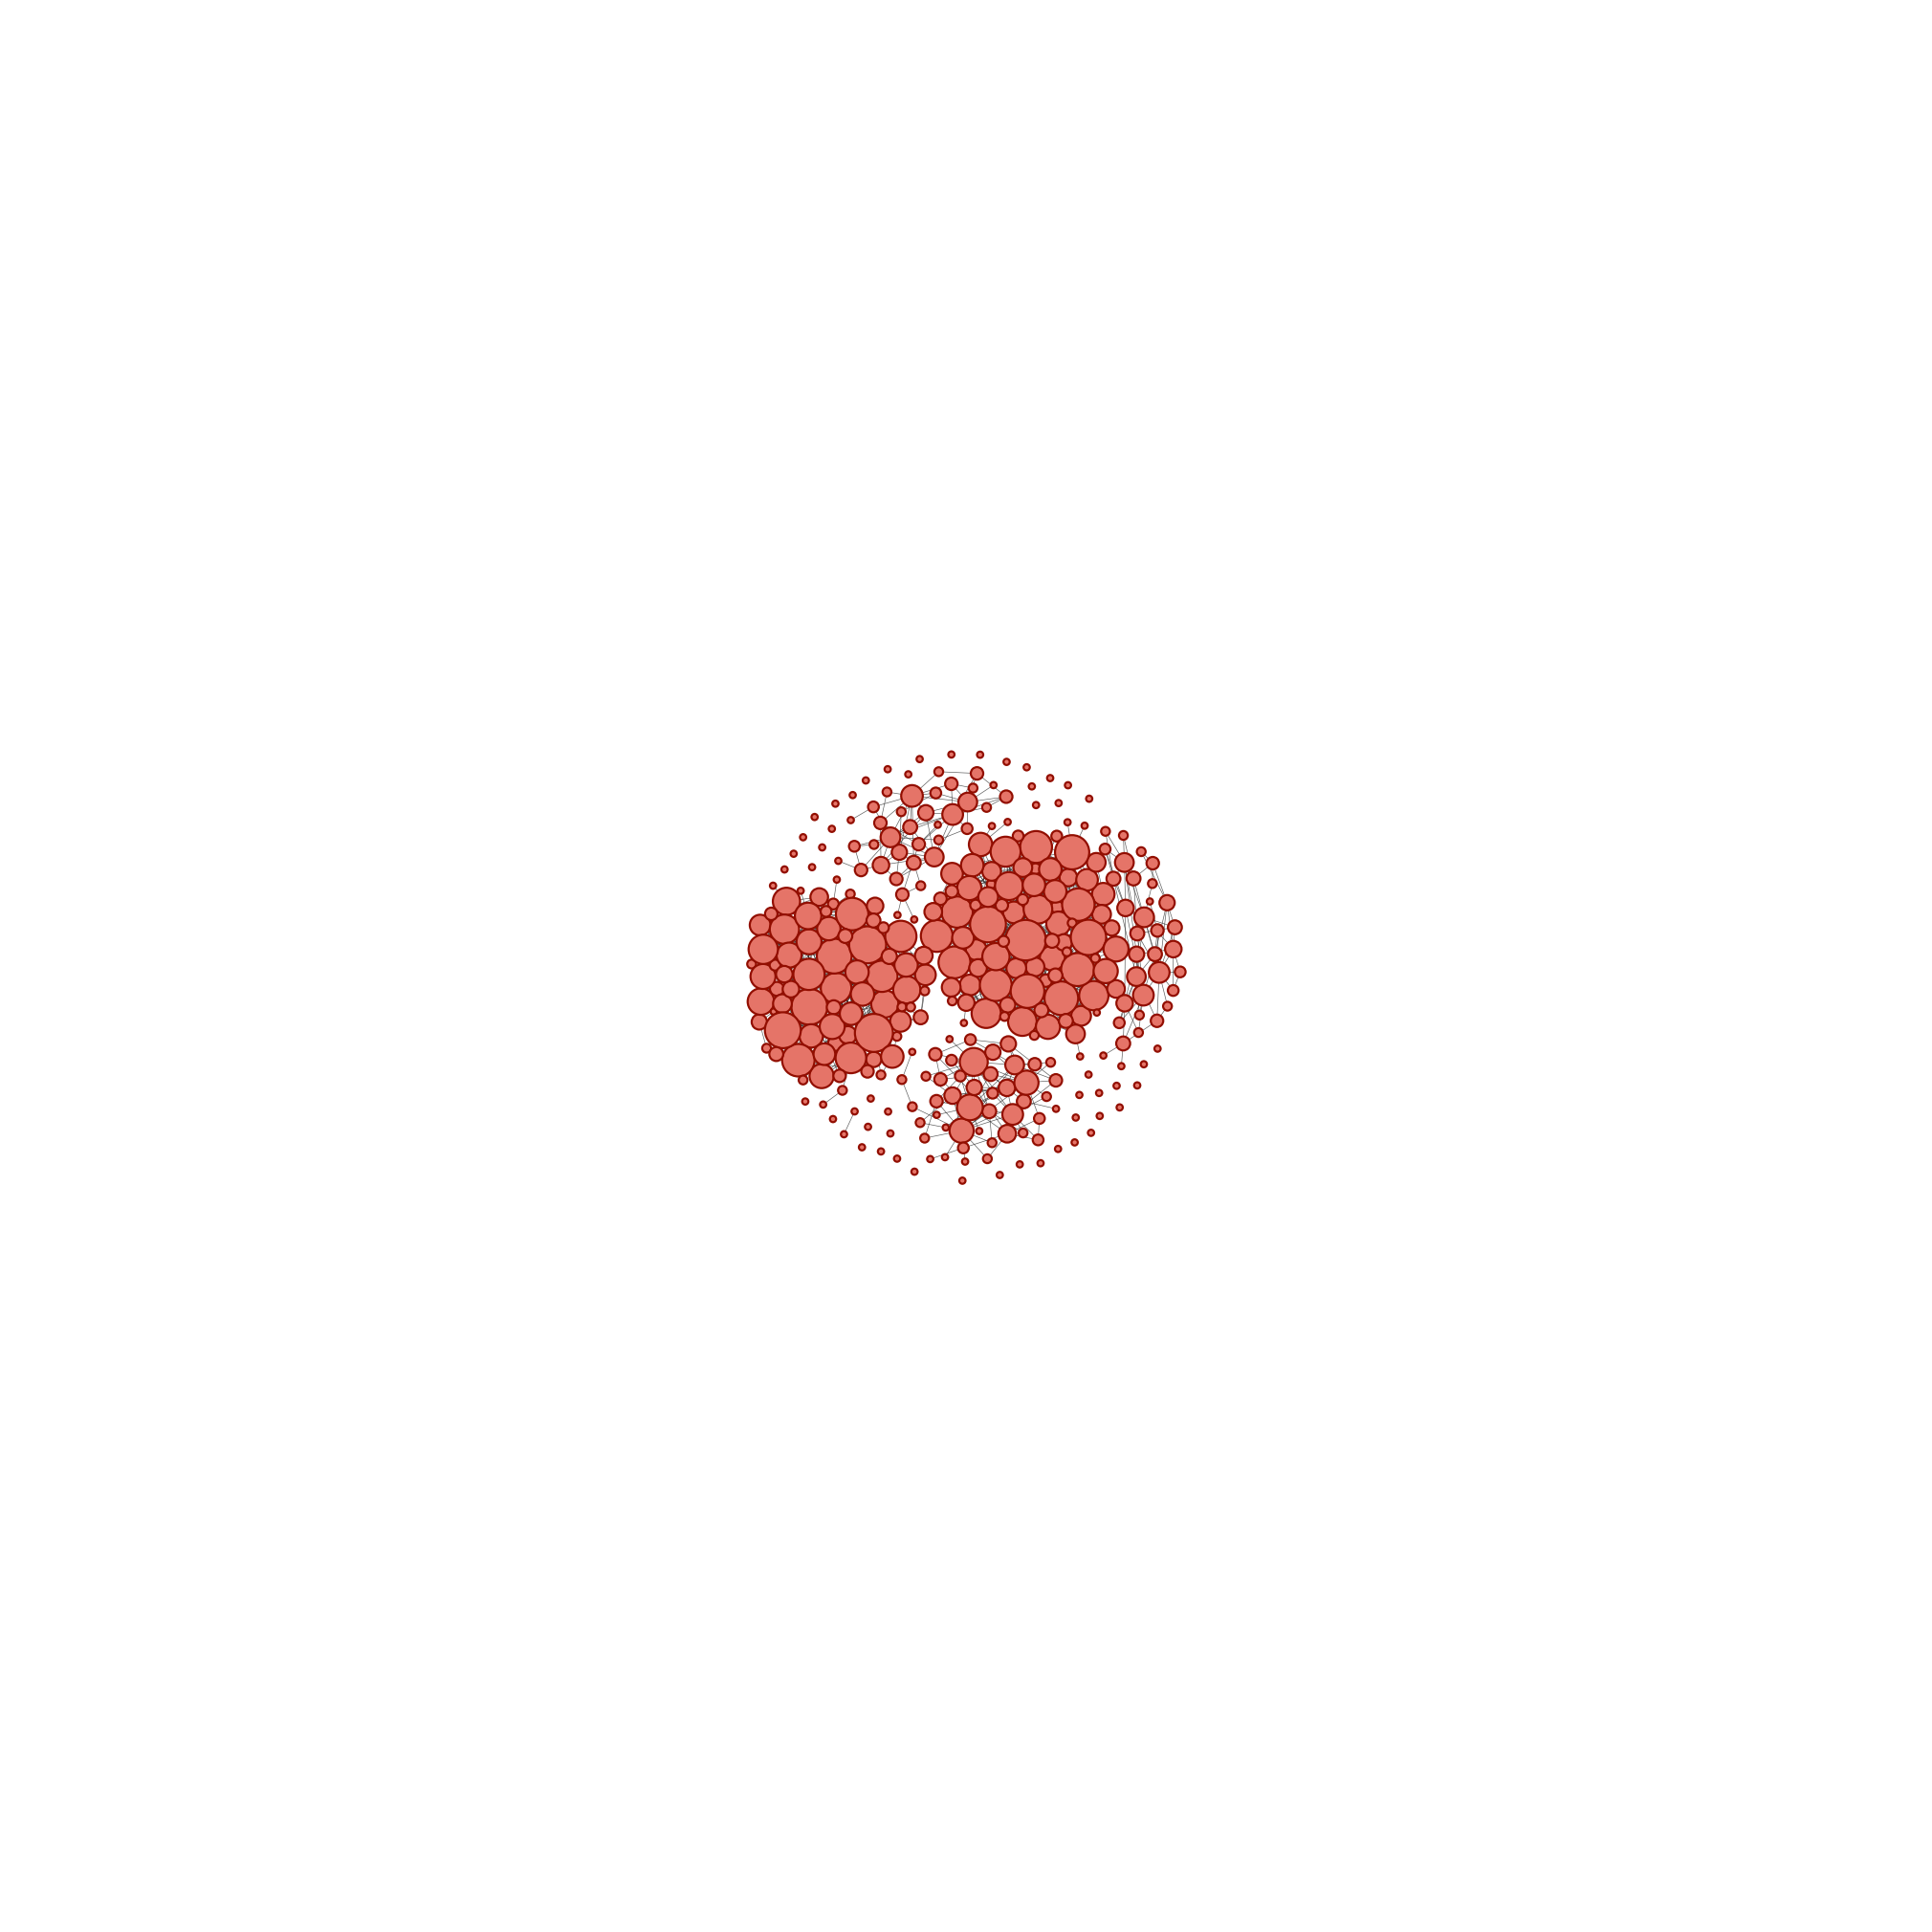

In [42]:
def netwulf_plot_(G, path="Network.pdf"):
    config_random_network = {
        # Input/output
        'zoom': 0.77,
        # Physics
        'node_charge': -58,
        'node_gravity': 0.85,
        'link_distance': 15,
        'link_distance_variation': 0,
        'node_collision': True,
        'wiggle_nodes': False,
        'freeze_nodes': False,
        # Nodes
        'node_fill_color': '#e57468',
        'node_stroke_color': '#920e00',
        'node_label_color': '#000000',
        'display_node_labels': False,
        'scale_node_size_by_strength': True,
        'node_size': 13.8,
        'node_stroke_width': 1,
        'node_size_variation': 0.5,
        # Links
        'link_color': '#2e2e2e',
        'link_width': 0.3,
        'link_alpha': 0.79,
        'link_width_variation': 0.5,
        # Thresholding
        'display_singleton_nodes': True,
        'min_link_weight_percentile': 0,
        'max_link_weight_percentile': 1
    }

    network, config = nw.visualize(G, plot_in_cell_below=False, config=config_random_network)

    fig, ax = nw.draw_netwulf(network, figsize=20)
    plt.savefig(path)

netwulf_plot_(G_rap_splittet)

In [46]:
def netwulf_plot_communities(G, communities, color_palette=None, path="Network.pdf", figsize=30):
    """
    Visualize a network with nodes colored by community
    
    Parameters:
    -----------
    G : networkx.Graph
        The network to visualize
    communities : dict or list
        Either a dictionary mapping node -> community_id or a list of lists where each inner list contains nodes of one community
    color_palette : list, optional
        List of colors (hex format) to use for communities. If None, default colors will be used.
    path : str, optional
        Path to save the figure
    figsize : int, optional
        Size of the figure
    """
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import netwulf as nw
    import numpy as np
    
    # Convert communities to dict format if it's a list of lists
    if isinstance(communities, list):
        comm_dict = {}
        for i, comm in enumerate(communities):
            for node in comm:
                comm_dict[node] = i
        communities = comm_dict
    
    # Create a copy of the graph to modify
    G_copy = G.copy()
    
    # Get unique community IDs
    unique_communities = sorted(set(communities.values()))
    num_communities = len(unique_communities)
    
    # Generate colors if not provided
    if color_palette is None:
        # Use a default color palette
        default_colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
        color_palette = [default_colors[i % len(default_colors)] for i in range(num_communities)]
    
    # Map community IDs to colors
    color_map = {comm_id: color_palette[i % len(color_palette)] for i, comm_id in enumerate(unique_communities)}
    
    # Add community and color as node attributes
    for node, comm_id in communities.items():
        G_copy.nodes[node]['community'] = comm_id
        G_copy.nodes[node]['color'] = color_map[comm_id]
    
    # Base configuration
    config = {
        # Input/output
        'zoom': 0.9,
        # Physics
        'node_charge': -93,
        'node_gravity': 0.85,
        'link_distance': 15,
        'link_distance_variation': 0,
        'node_collision': True,
        'wiggle_nodes': False,
        'freeze_nodes': False,
        # Nodes
        'node_stroke_color': '#555555',
        'node_label_color': '#000000',
        'display_node_labels': False,
        'scale_node_size_by_strength': True,
        'node_size': 13.8,
        'node_stroke_width': 1,
        'node_size_variation': 0.5,
        # Links
        'link_color': '#2e2e2e',
        'link_width': 0.3,
        'link_alpha': 0.79,
        'link_width_variation': 0.5,
        # Thresholding
        'display_singleton_nodes': True,
        'min_link_weight_percentile': 0,
        'max_link_weight_percentile': 1
    }
    
    # First visualize to get the network positions
    network, config = nw.visualize(G_copy, plot_in_cell_below=False, config=config)
    
    # Now we need to manually modify the network properties to set node colors based on community
    for node_data in network['nodes']:
        node_id = node_data['id']
        if node_id in communities:
            node_data['color'] = color_map[communities[node_id]]
    
    # Draw and save the figure
    fig, ax = nw.draw_netwulf(network, figsize=figsize)
    plt.savefig(path)
    
    return fig, ax, network, config

(<Figure size 3000x3000 with 1 Axes>,
 <Axes: >,
 {'xlim': [0, 704],
  'ylim': [0, 704],
  'linkColor': '#2e2e2e',
  'linkAlpha': 0.79,
  'nodeStrokeColor': '#555555',
  'nodeStrokeWidth': 1.3614564585352347,
  'links': [{'source': 'Fuego',
    'target': 'Sensato',
    'width': 0.40843693756057037,
    'weight': 1},
   {'source': 'Fuego',
    'target': 'A.CHAL',
    'width': 0.40843693756057037,
    'weight': 1},
   {'source': 'Fuego',
    'target': 'Juicy J',
    'width': 0.40843693756057037,
    'weight': 1},
   {'source': 'Fuego',
    'target': 'Pitbull',
    'width': 0.40843693756057037,
    'weight': 1},
   {'source': 'Fuego',
    'target': 'Dillon Francis',
    'width': 0.40843693756057037,
    'weight': 1},
   {'source': 'Cardi B',
    'target': 'Steve Aoki',
    'width': 0.40843693756057037,
    'weight': 1},
   {'source': 'Cardi B',
    'target': 'Lizzo',
    'width': 0.40843693756057037,
    'weight': 1},
   {'source': 'Cardi B',
    'target': 'G-Eazy',
    'width': 0.4084369

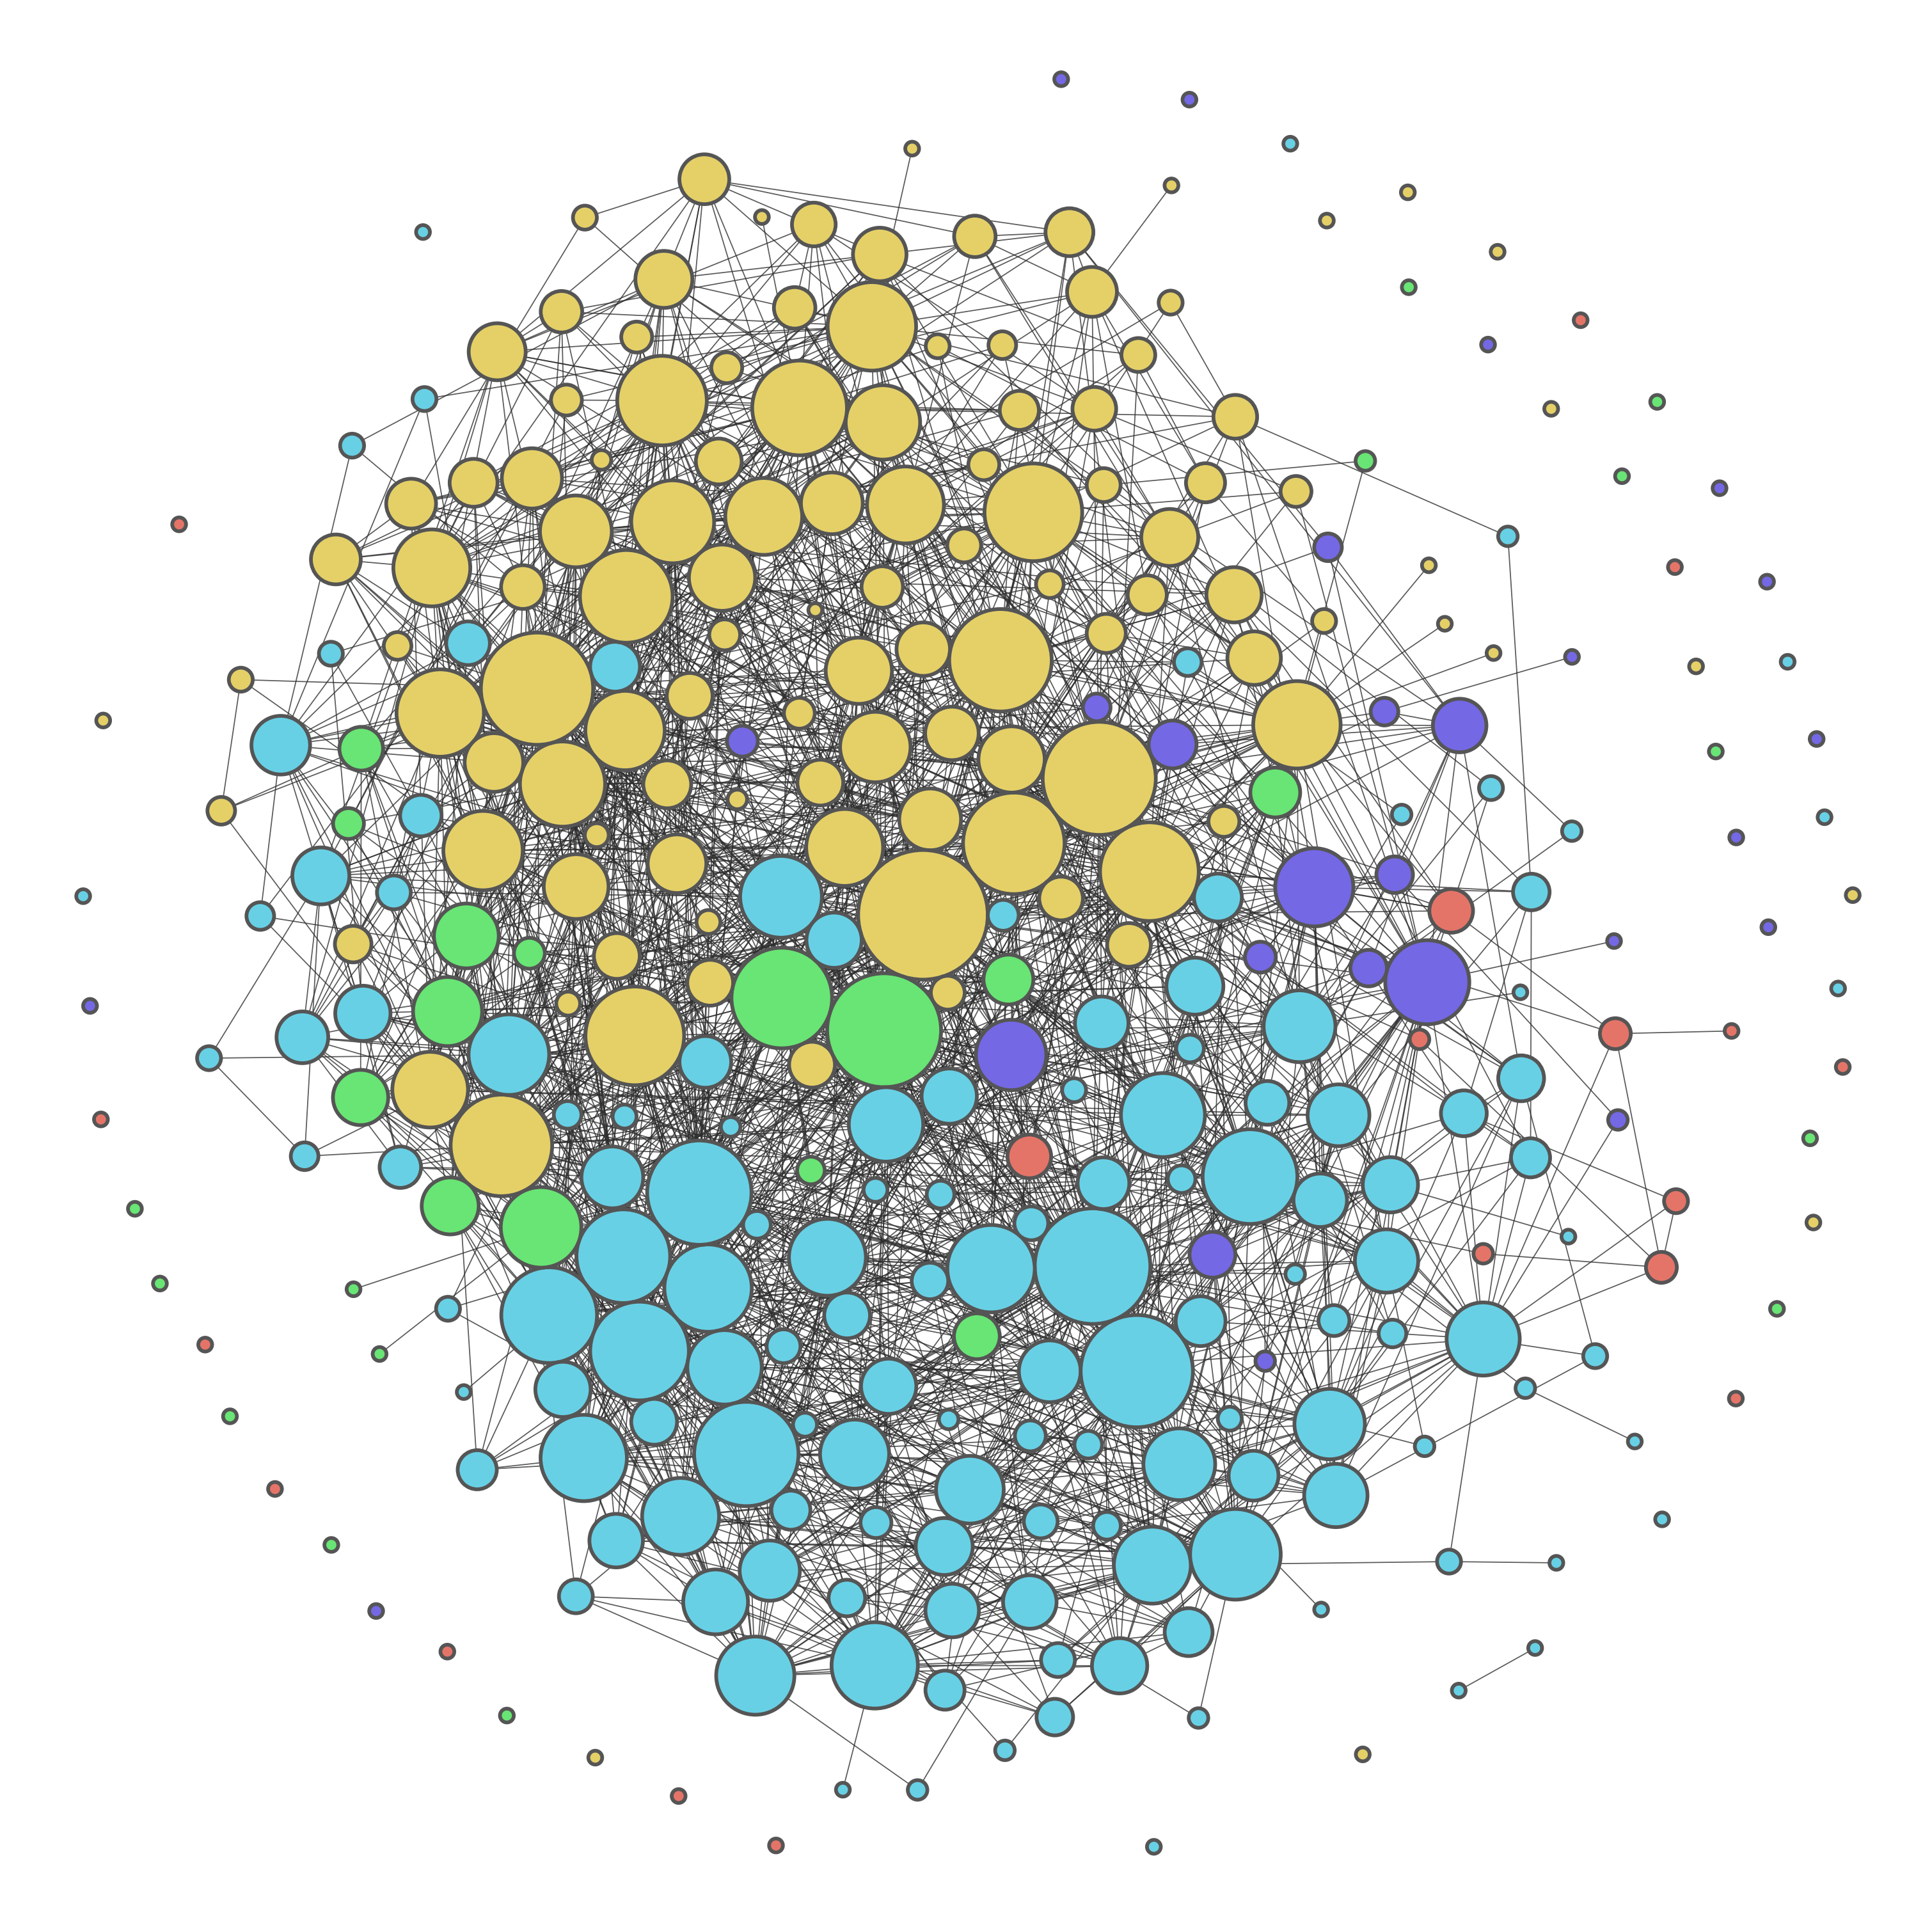

In [48]:
# Example usage:
import networkx as nx
from community import community_louvain  # or any other community detection algorithm

# Your graph
G = G_rap

# Get communities (example using Louvain method)
communities = community_louvain.best_partition(G)

# Create custom color palette (optional)
colors = ['#e57468', '#68e574', '#7468e5', '#e5d068', '#68d0e5']

# Plot with communities
netwulf_plot_communities(G_rap, communities, color_palette=colors, path="Network_communities.pdf")

## Fetch text data

In [40]:
combined_df = pd.concat([pop_df, rap_df])
artists_df = combined_df[['spotify_id', 'name']].drop_duplicates()

artists_df['representative_text'] = ''

artists_df = artists_df.reset_index(drop=True)

print(f"Total count of unique pop and rap artists: {len(artists_df)}")
artists_df.head()

Total count of unique pop and rap artists: 696


spotify_id               name representative_text
0  2l35CQqtYRh3d8ZIiBep4v               MKTO                    
1  7EK1bQADBoqbYXnT4Cqv9w        John Denver                    
2  2vm8GdHyrJh2O2MfbQFYG0  Ingrid Michaelson                    
3  4kYSro6naA4h99UJvo89HB            Cardi B                    
4  0tzSBCPJZmHTdOA3ZV2mN3                 CL

In [41]:
import lyricsgenius
import concurrent.futures
import time
import csv

genius = lyricsgenius.Genius("SQ5PQucPjwa_LEDaobBQyxewdh80ZB-KhaBau73yASMRNIvnijWprQSi6ZDnUb7N", timeout=10, retries=3, remove_section_headers=True)
test_artists = artists_df["name"].tolist()

ModuleNotFoundError: No module named 'lyricsgenius'

In [8]:
def fetch_top3(name): 
    try: 
        artist = genius.search_artist(name, max_songs=3, sort="popularity")
        if artist: 
            lyrics = []
            for song in artist.songs:
                lyr = (song.lyrics).split("Lyrics")[1]
                lyrics.append(lyr)
            
            return {"Artist": name ,"Lyrics": lyrics}
        
    except Exception as e:
        print(f"Error fetching song by {name}: {e}")
        return None 

In [ ]:
for i in range(0,len(test_artists),4): 
    batch = test_artists[i: i+4]
    rows = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        future_to_song = {executor.submit(fetch_top3, artist): artist for artist in batch}
        for future in concurrent.futures.as_completed(future_to_song):
            result = future.result()
            if result:
                rows.append(result)
    #for name in batch: 
    #    rows.append(fetch_top3(name))
    
     # Append to file
    with open("Artist_text.csv", mode="a", encoding="utf-8", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["Artist", "Lyrics"])
        writer.writerows(rows)

Searching for songs by Juice...
Searching for songs by Yomi...


Searching for songs by Ray Dalton...

Searching for songs by Kiana Ledé...

Changing artist name to 'YOMi'
Changing artist name to 'Juice WRLD'
Song 1: "Unnskyld"
Song 1: "EX"
Song 2: "I Choose You"
Song 2: "Kom nærmere"
Song 3: "Fairplay"

Reached user-specified song limit (3).
Done. Found 3 songs.
Song 3: "Erfaring"

Reached user-specified song limit (3).
Done. Found 3 songs.
Song 1: "Lucid Dreams"
Song 1: "Manila"
Song 2: "In My Bones"
Song 2: "All Girls Are the Same"
Song 3: "ALL WE GOT"

Reached user-specified song limit (3).
Done. Found 3 songs.
Song 3: "Wishing Well"

Reached user-specified song limit (3).
Done. Found 3 songs.
Searching for songs by Phoebe Ryan...

Searching for songs by MKTO...

Searching for songs by Joe Stone...

Searching for songs by Agnes...

Changing artist name to 'AGNEZ MO'
Song 1: "Damn I Love You"
Song 1: "Classic"
Song 1: "Is It Really Love"
Song 2: "Karena Ku Sanggup"
Song 2: "American

: 

: 

In [114]:
rows

[{'Artist': 'Yomi',
  'Lyrics': ["\n\nJeg skulle hørt på deg først\nOg ikke på meg selv\nOg ikke på meg selv\nMen om det er til no' trøst\nSå er ingenting bestemt\nJa, ingenting er bestemt\nVet du føler at jeg svikta deg (Svikta deg)\nNår alt jeg prøvde var å vise vei (Vise vei)\nMen jeg tror jeg leste skiltet feil\n\nSå la meg bare si unnskyld, okei?\nHører du meg?\nHører du meg?\nHører du meg?\nJa, det er bare min skyld, okei?\nHører du meg?\nHører du meg?\nHører du meg?\nHører du meg?\nHører du meg?\nHører du meg?\nHører du meg?\n\nDu skulle sett deg selv\nSånn jeg så deg først, sånn jeg så deg først\nDu så ut som en drøm\nHenda som en bønn\nMynter i en brønn\n\nSå la meg bare si unnskyld, okei?\nHører du meg?\nHører du meg?\nHører du meg?\nJa, det er bare min skyld, okei?\nHører du meg?\nHører du meg?\nHører du meg?\nHører du meg?\nHører du meg?\nHører du meg?\nHører du meg?\nHører du meg?\n\nDet va’kke dagen min\n(Det va'kke dagen min\nDet va'kke dagen min)\nDet va’kke dagen min\n

In [137]:
df_tes = pd.read_csv("Artist_text.csv")
df_tes["Lyrics"] = df_tes["Lyrics"].apply(ast.literal_eval)